# 7장. XGBoost로 외계 행성 찾기

*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/handson-gb/blob/main/Chapter07/Discovering_Exoplanets.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-gb/blob/main/Chapter07/Discovering_Exoplanets.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.3 MB/s eta 0:00:00
Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
   creating: __MACOSX/
  inflating: __MACOSX/._exoplanets.csv  


In [196]:
# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

## 외계 행성 찾기

### 외계 행성 데이터셋

In [2]:
import pandas as pd
df = pd.read_csv('exoplanets.csv', nrows=400)


In [6]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [7]:
df['LABEL'].value_counts()

df[df['LABEL'] == 2].index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36],
      dtype='int64')

# EDA


0 ~ 36 : 외계행성이 존재하는 행성 ,
36 ~ : 외계행성이 존재하지 않는 행성

## 시계열 플롯(Line Plot) / 그래프 시각화

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

X = df.iloc[:,1:]
y = df.iloc[:,0] - 1



def light_plot(index):
    y_vals = X.iloc[index]
    x_vals = np.arange(len(y_vals))
    plt.figure(figsize=(15,8))
    plt.xlabel('Number of Observations')
    plt.ylabel('Light Flux')
    plt.title('Light Plot ' + str(index), size=15)
    plt.plot(x_vals, y_vals)
    plt.show()

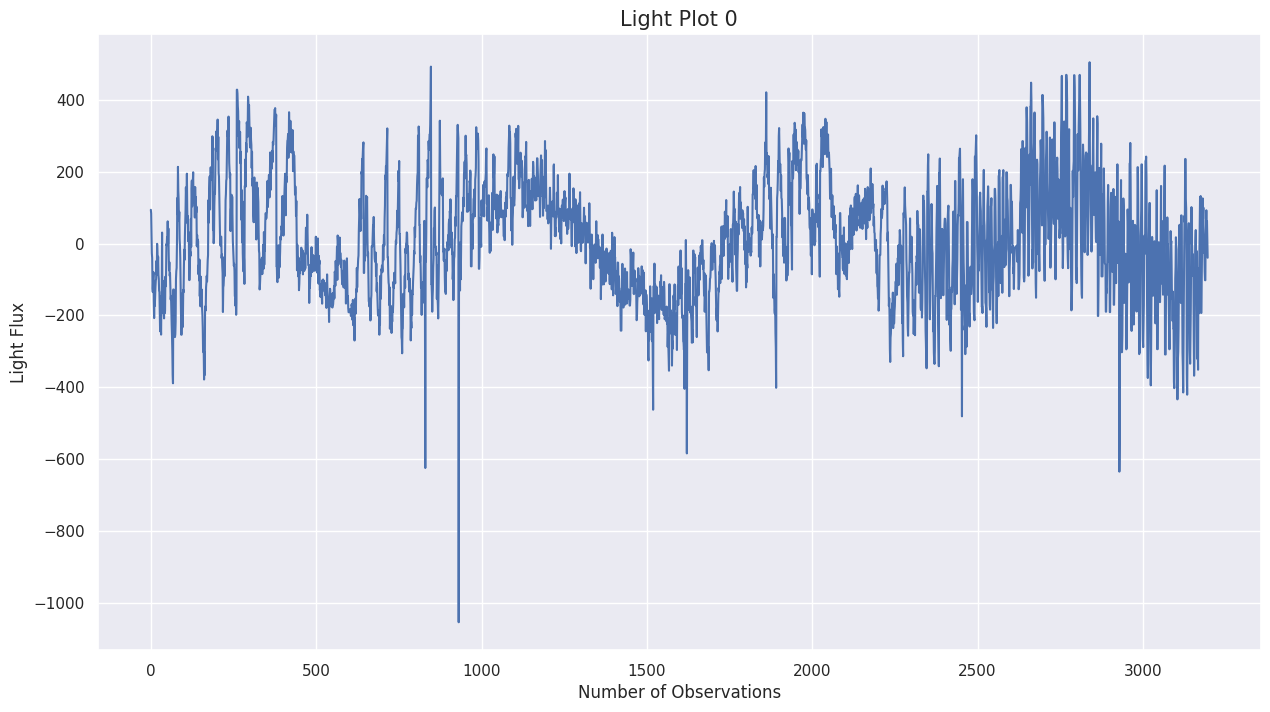

In [115]:
light_plot(0)

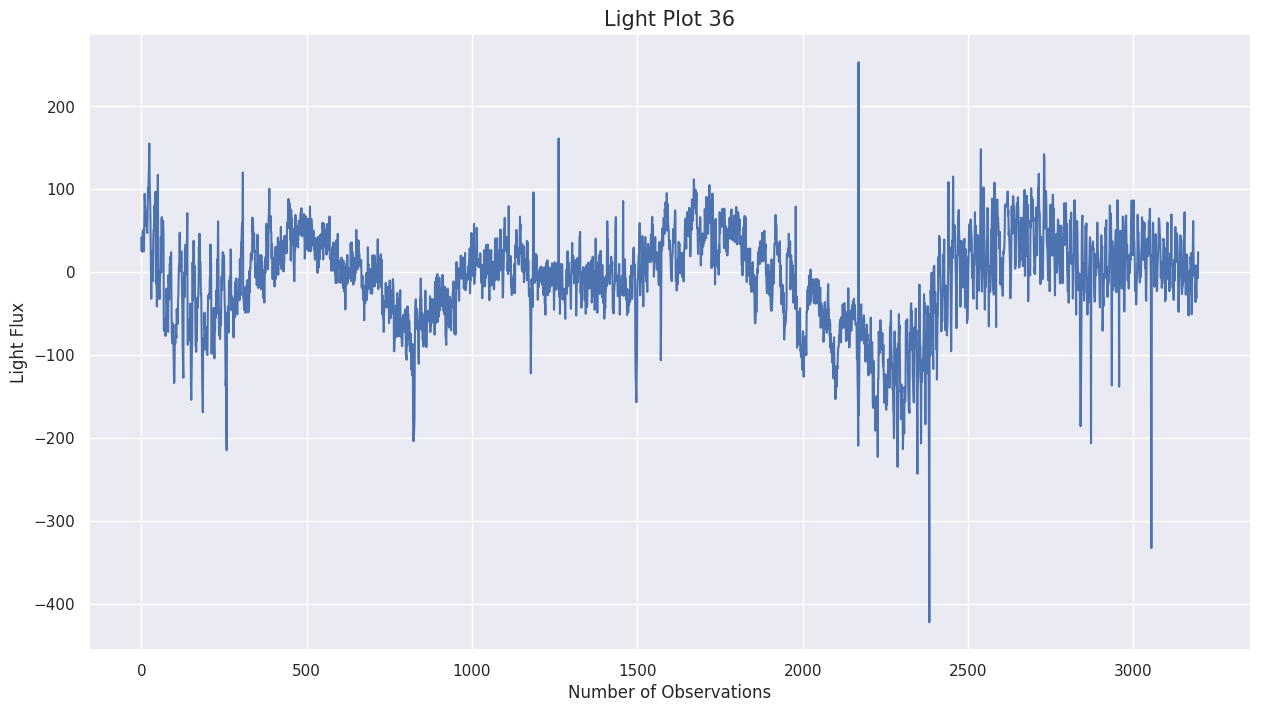

In [19]:
light_plot(36)

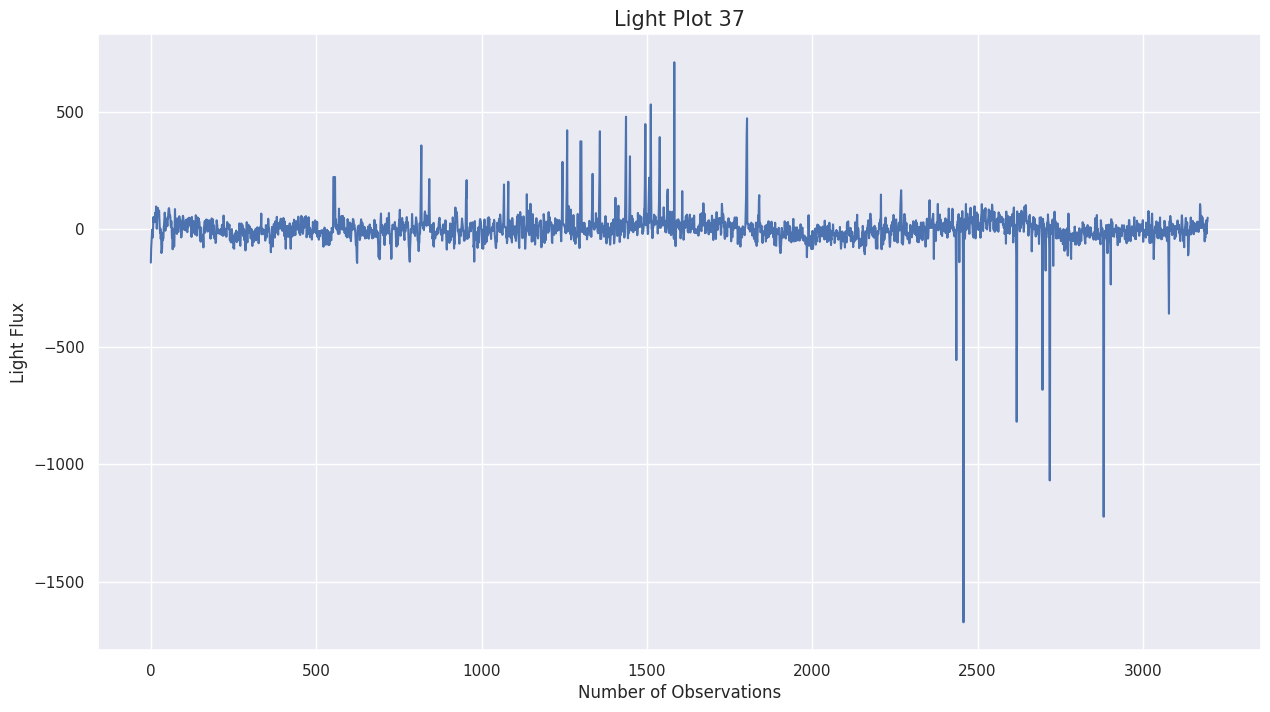

In [20]:
light_plot(37)

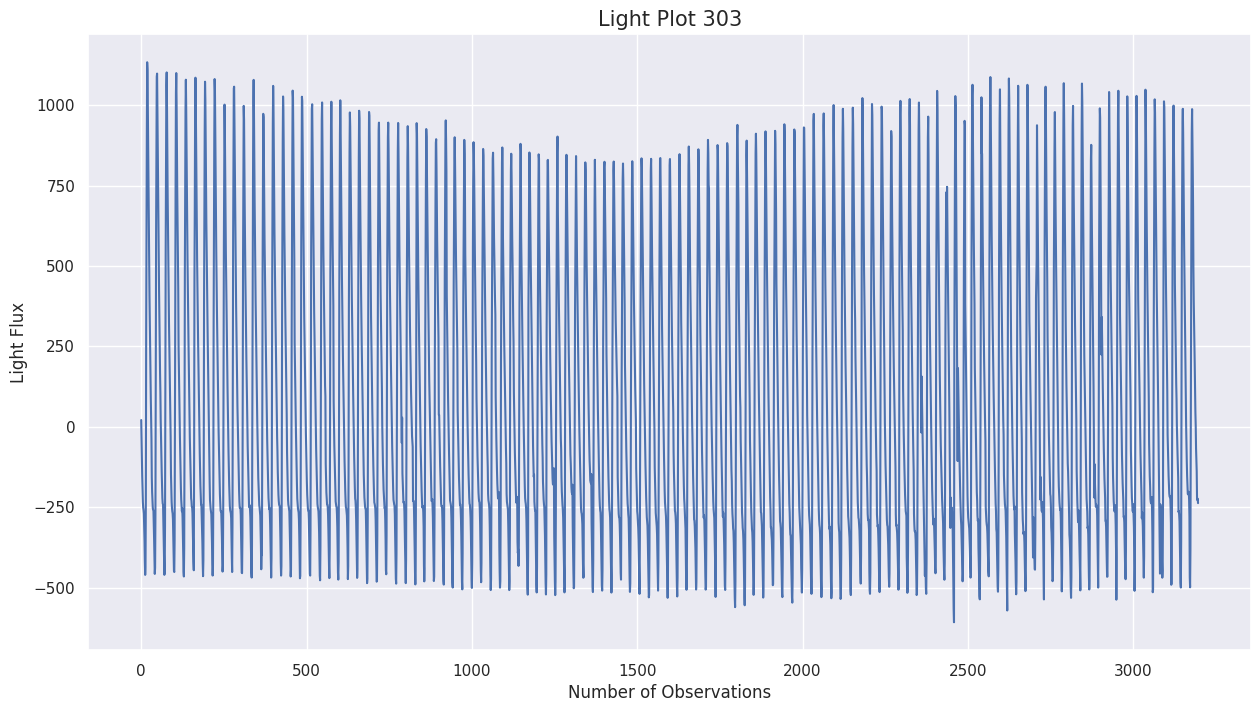

In [74]:
light_plot(303)

## Moving Average를 사용한 추세와 계절성 분리

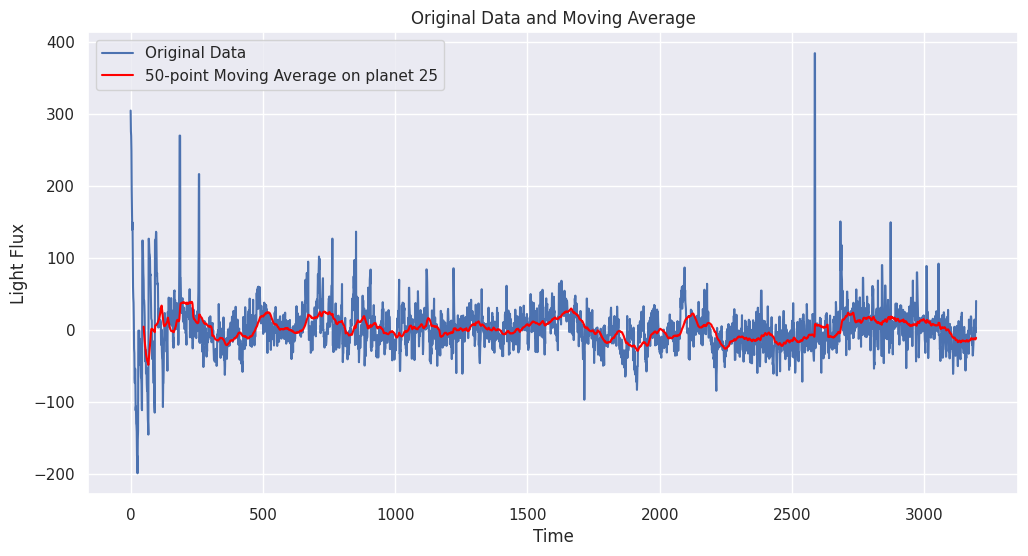

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

index = 25
# 데이터 준비 (시계열 데이터)
series = pd.Series(data=X.iloc[index, :].values)  # 첫 번째 샘플 사용

# 이동 평균 계산
window = 50  # 이동 평균 창 크기
rolling_mean = series.rolling(window=window).mean()

# 원본 데이터와 이동 평균 시각화
plt.figure(figsize=(12, 6))
plt.plot(series, label='Original Data')
plt.plot(rolling_mean, label=f'{window}-point Moving Average on planet {index}', color='red')
plt.title('Original Data and Moving Average')
plt.xlabel('Time')
plt.ylabel('Light Flux')
plt.legend()
plt.show()


## 자기상관 플롯 (Autocorrelation Plot)

In [87]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# ACF 계산 및 시각화
def acf_plot(index):
  plt.figure(figsize=(12, 6))

  # Lag를 10 단위로 10개 생성
  lags = range(10, 1501, 10)

  plot_acf(X.iloc[index, :], lags=lags)  # 'data=' 대신 직접 X.iloc[0, :] 전달
  plt.title("Autocorrelation Function")
  plt.xlabel("Lag")
  plt.ylabel("Autocorrelation")
  plt.show()



<Figure size 1200x600 with 0 Axes>

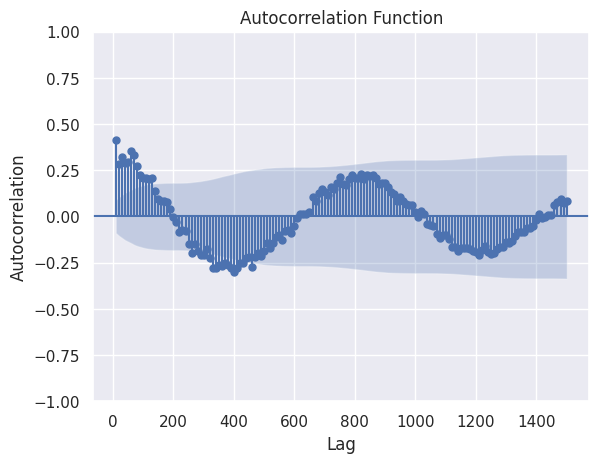

In [88]:
acf_plot(0)

<Figure size 1200x600 with 0 Axes>

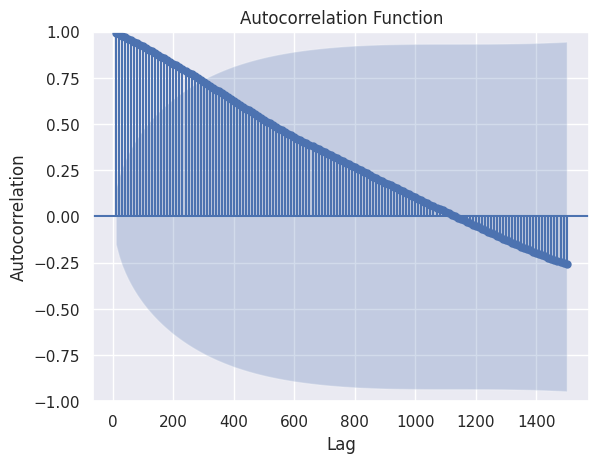

In [91]:
acf_plot(14)

<Figure size 1200x600 with 0 Axes>

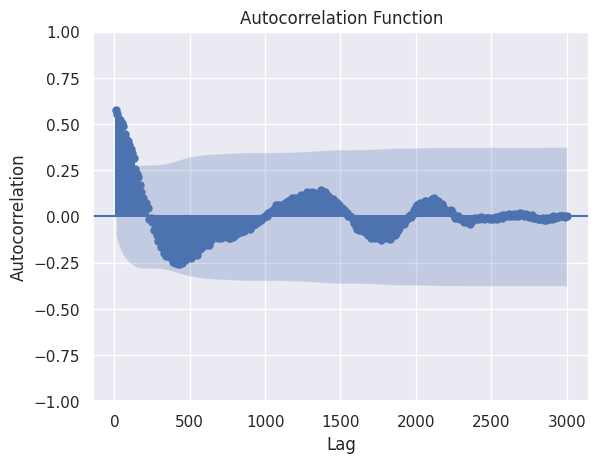

In [77]:
acf_plot(36)

<Figure size 1200x600 with 0 Axes>

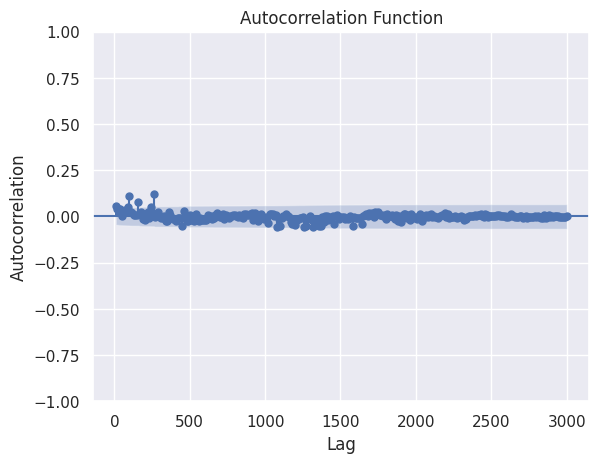

In [78]:
acf_plot(37)

<Figure size 1200x600 with 0 Axes>

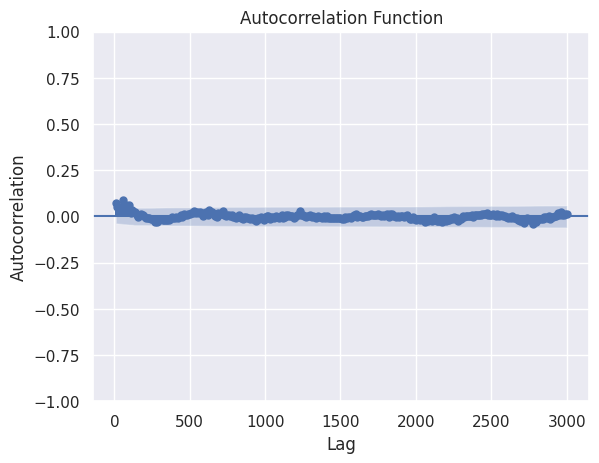

In [82]:
acf_plot(60)

# 데이터 전처리

### 데이터 준비

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [17]:
# 누락된 값의 개수를 셉니다.
df.isnull().sum().sum()

0

# 푸리에 변환을 통한 주파수 분석

[ 0.          0.00031279  0.00062559 ... -0.00093838 -0.00062559
 -0.00031279]
[-23747.1           -0.j          18790.20909191 +2071.37036098j
   4820.58048863-22523.93822939j ...   -846.76375706-23928.72417958j
   4820.58048863+22523.93822939j  18790.20909191 -2071.37036098j]


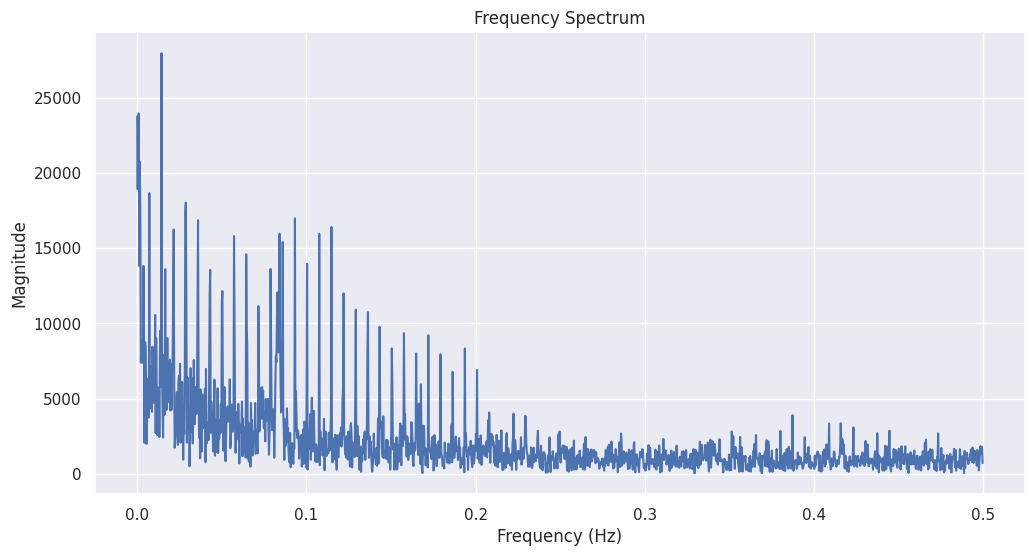

In [196]:
from scipy.fft import fft, fftfreq

# 샘플 하나에 대해 FFT 적용
sample_num = 0
sample_flux = X.iloc[1,:]  # 첫 번째 샘플 ( 존재 o )
n = len(sample_flux)  # 데이터 포인트 개수
timestep = 1  # 샘플 간 간격 ( 주기적으로 샘플링 되었으므로 1로 통일 )

# 푸리에 변환 수행
freq = fftfreq(n, d=timestep)  # 주파수 값
fft_result = fft(sample_flux.to_numpy())  # FFT 결과

print(freq)
print(fft_result)

# 진폭 계산
magnitude = np.abs(fft_result)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(freq[:n // 2], magnitude[:n // 2])  # 양의 주파수 성분만 시각화
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()



### 푸리에 변환 + 저주파( < 1/9 Hz ) 필터링

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# FFT 수행 함수 정의
def perform_fft(samples, timestep=1):
    """
    여러 샘플에 대해 FFT를 수행합니다.
    :param samples: 시계열 데이터가 포함된 DataFrame 또는 numpy array (행: 샘플, 열: 시계열 데이터)
    :param timestep: 샘플 간 간격 (1/샘플링 주파수)
    :return: 주파수 값과 모든 샘플의 FFT 결과 (진폭)
    """
    fft_results = []
    freq = None

    for i, sample in enumerate(samples):
        n = len(sample)
        if freq is None:
            freq = fftfreq(n, d=timestep)  # 주파수 값 생성
        fft_result = fft(sample)  # FFT 수행
        magnitude = np.abs(fft_result)  # 진폭 계산
        fft_results.append(magnitude[:n // 2])  # 양의 주파수 성분만 저장

    return freq[:len(freq) // 2], np.array(fft_results)

# 샘플 데이터 준비 (예: X는 DataFrame)
# X = pd.DataFrame(...)  # 실제 시계열 데이터로 대체

def lowPassFilter(freq, fft_results):

  # 진동수 1/9 미만의 저주파만 남기기
  # 행성의 최소 공전주기는 4시간 30분. 이므로 측정 간격 30분을 고려할 때 최소 주기를 9로 잡음
  low_freq_threshold = 1 / 9  # 저주파 한계 (Hz)
  low_freq_indices = np.where(freq < low_freq_threshold)[0]  # 해당 주파수 인덱스 찾기

  # 저주파 성분만 유지
  filtered_fft_results = np.zeros_like(fft_results)
  for i in range(len(fft_results)):
      filtered_fft_results[i, low_freq_indices] = fft_results[i, low_freq_indices]
  filtered_fft_results_df = pd.DataFrame(filtered_fft_results, columns=[f'Freq_{i}' for i in range(len(freq)) ]  )


  return filtered_fft_results_df


# FFT 수행
timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
freq, fft_results = perform_fft(X.to_numpy(), timestep=timestep)
filtered_fft_results_df = lowPassFilter(freq, fft_results)

print(filtered_fft_results_df)







       Freq_0         Freq_1         Freq_2         Freq_3         Freq_4  \
0    31822.48    3542.697260   55671.612807   52952.701956  200751.502826   
1    23747.10   18904.034831   23034.013754   23943.701671   13819.563577   
2    26180.51  143610.487591   41912.294689  365999.616787  104066.520704   
3    14855.14   12371.439885   33309.457851   69042.125217   64290.918441   
4    45527.39  310414.084694  140433.251401  400661.916141  406211.307176   
..        ...            ...            ...            ...            ...   
395   3950.73   12809.465846    7028.038243    9651.681584   10948.045682   
396   1379.68   23210.404025   55121.632312    9058.160211   17968.571004   
397  10651.43   15300.171644   38641.532429   55454.206752   51170.664464   
398  43330.29    3914.902683   30634.361653   44838.166768  108290.026105   
399  12080.01   11928.730666   19698.348544   25306.948095   14849.012669   

            Freq_5         Freq_6        Freq_7        Freq_8         Freq_

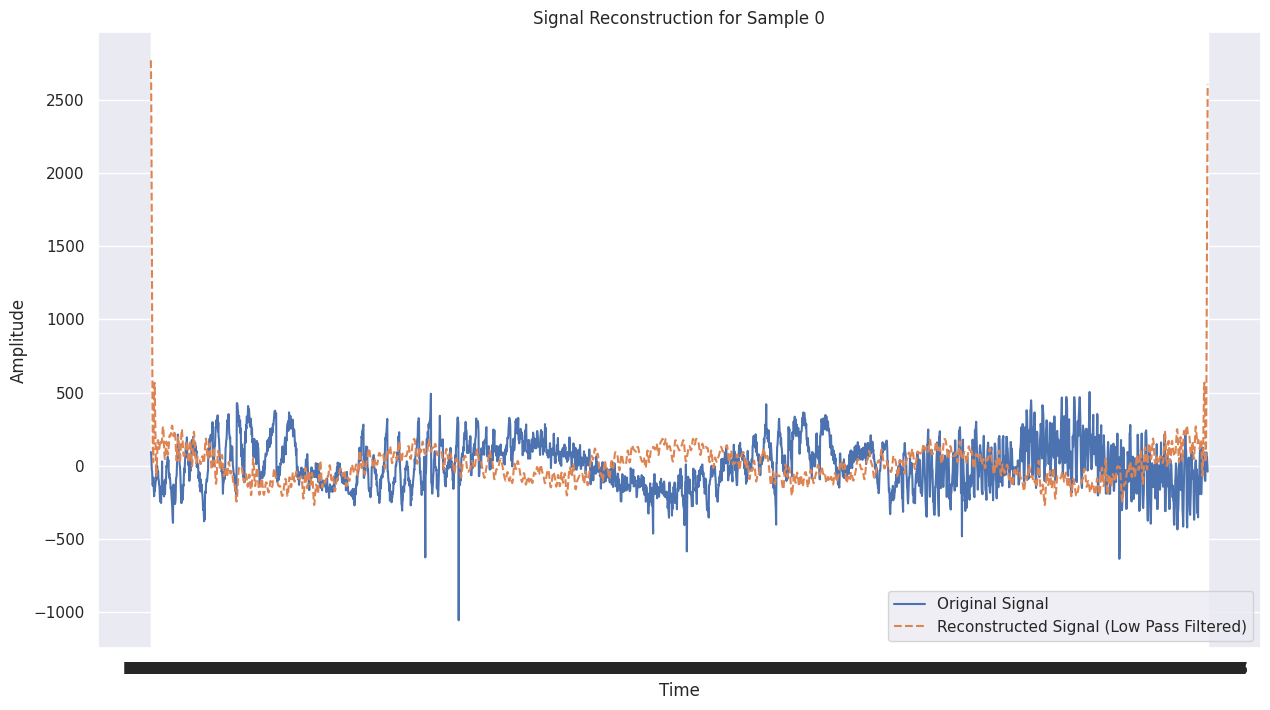

In [197]:
from scipy.fft import ifft

def reconstruct_signal(filtered_fft_results, freq, original_length):
    """
    필터링된 FFT 결과로부터 신호를 복원합니다.
    :param filtered_fft_results: 저주파 필터링된 FFT 결과 (DataFrame 또는 numpy array)
    :param freq: 주파수 값 (1D array)
    :param original_length: 원본 신호의 길이
    :return: 복원된 신호 (numpy array)
    """
    reconstructed_signals = []

    # 필터링된 FFT 결과를 복원할 수 있는 형태로 변환
    for fft_result in filtered_fft_results.values:
        # 양의 주파수 성분을 완성
        full_fft_result = np.zeros(original_length, dtype=complex)
        half_length = len(fft_result)

        # FFT 복원 크기 맞추기 (홀수/짝수 여부 처리)
        full_fft_result[:half_length] = fft_result
        if original_length % 2 == 0:
            full_fft_result[-half_length:] = np.conj(fft_result[::-1])
        else:
            full_fft_result[-(half_length - 1):] = np.conj(fft_result[1:][::-1])

        # IFFT를 통해 시계열 신호 복원
        reconstructed_signal = np.real(ifft(full_fft_result))
        reconstructed_signals.append(reconstructed_signal)

    return np.array(reconstructed_signals)

# 복원 신호 생성
original_length = X.shape[1]  # 원본 신호의 길이
reconstructed_signals = reconstruct_signal(filtered_fft_results_df, freq, original_length)

# 복원 신호 시각화 (샘플 중 하나)
sample_index = 0  # 예: 첫 번째 샘플 선택
plt.figure(figsize=(15, 8))
plt.plot(X.iloc[sample_index, :], label='Original Signal')
plt.plot(reconstructed_signals[sample_index], label='Reconstructed Signal (Low Pass Filtered)', linestyle='--')
plt.title(f"Signal Reconstruction for Sample {sample_index}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


### 초기 XGBClassifier

원래는 학습 과정에서 Test set 을 사용하면 안되지만,
최종 결과와의 차이를 직관적으로 비교하고자 사용하였습니다.
이후 코드에서 XGB 튜닝을 하기 앞서서 교차 검증 StratifiedKFold 방법을 통하여 성능을 검증합니다.

In [117]:
# XGBRegressor를 임포트합니다.
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

# train_test_split를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(filtered_fft_results_df, y, random_state=2)

In [118]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier(booster='gbtree')

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))

점수: 0.93


## 오차 행렬 분석하기

### confusion_matrix

In [119]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[88,  0],
       [ 7,  5]])

### classification_report

In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        88
           1       1.00      0.42      0.59        12

    accuracy                           0.93       100
   macro avg       0.96      0.71      0.77       100
weighted avg       0.94      0.93      0.92       100



### 다른 측정 방법

####  recall_score

In [114]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.4444444444444444

## 불균형 데이터 리샘플링

### 언더샘플링

#### xgb_clf 함수

In [127]:
def xgb_clf(model, nrows):

    df = pd.read_csv('exoplanets.csv', nrows=nrows) # nrows 개만 fetching
    # 데이터를 X와 y로 나눕니다.
    X = df.iloc[:,1:]

    # FFT 수행
    timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
    freq, fft_results = perform_fft(X.to_numpy(), timestep=timestep)
    filtered_fft_results_df = lowPassFilter(freq, fft_results)

    y = df.iloc[:,0] - 1

    # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
    X_train, X_val, y_train, y_val = train_test_split(filtered_fft_results_df, y, random_state=2)

    # 훈련 세트에서 모델을 훈련합니다.
    model.fit(X_train, y_train)

    # 테스트 세트에 대한 예측을 만듭니다.
    y_pred = model.predict(X_test)

    score = recall_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))

    print(classification_report(y_test, y_pred))

    return score

#### 언더샘플링 테스트

In [128]:
xgb_clf(XGBClassifier(), nrows=800)

[[88  0]
 [ 4  8]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        88
           1       1.00      0.67      0.80        12

    accuracy                           0.96       100
   macro avg       0.98      0.83      0.89       100
weighted avg       0.96      0.96      0.96       100



0.6666666666666666

In [129]:
xgb_clf(XGBClassifier(), nrows=200)

[[88  0]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       1.00      0.92      0.96        12

    accuracy                           0.99       100
   macro avg       0.99      0.96      0.98       100
weighted avg       0.99      0.99      0.99       100



0.9166666666666666

In [130]:
xgb_clf(XGBClassifier(), nrows=74)

[[70 18]
 [ 2 10]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88        88
           1       0.36      0.83      0.50        12

    accuracy                           0.80       100
   macro avg       0.66      0.81      0.69       100
weighted avg       0.90      0.80      0.83       100



0.8333333333333334

### 오버샘플링

In [131]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [132]:
newdf = pd.DataFrame(np.repeat(df_train[df_train['LABEL']==1].values,
                               9,axis=0))
newdf.columns = df_train.columns
df_train_resample = pd.concat([df_train, newdf])

df_train_resample['LABEL'].value_counts()

,count
LABEL,
0.0,275
1.0,250


In [133]:
X_train_resample = df_train_resample.iloc[:,1:]
y_train_resample = df_train_resample.iloc[:,0]

In [134]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier()

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train_resample, y_train_resample)

# 테스트 세트에 대해 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[87  1]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        88
           1       0.86      0.50      0.63        12

    accuracy                           0.93       100
   macro avg       0.90      0.74      0.80       100
weighted avg       0.93      0.93      0.92       100

0.5


## XGBClassifier 튜닝

### 가중치 조정하기

#### replace 메서드

In [144]:

df = pd.read_csv('exoplanets.csv',nrows=400) # nrows 개만 fetching

df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

df['LABEL'].value_counts()

,count
LABEL,
0,363
1,37


#### scale_pos_weight

In [145]:
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]

# FFT 수행
timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
freq, fft_results = perform_fft(X.to_numpy(), timestep=timestep)
filtered_fft_results_df = lowPassFilter(freq, fft_results)

y = df.iloc[:,0]


X_train, X_test, y_train, y_test = train_test_split(filtered_fft_results_df, y, test_size=0.2, random_state=2)


In [127]:
weight = 100
model = XGBClassifier(scale_pos_weight=weight)

model.fit(X_train, y_train)

# 검증 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)


[[71  0]
 [ 5  4]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        71
           1       1.00      0.44      0.62         9

    accuracy                           0.94        80
   macro avg       0.97      0.72      0.79        80
weighted avg       0.94      0.94      0.93        80

0.4444444444444444


### XGBClassifier 튜닝

#### 기준 모델

In [157]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold, cross_val_score, cross_val_predict

In [158]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
model = XGBClassifier(scale_pos_weight=10)

# 교차 검증에서 각 Fold의 예측값 얻기
y_pred = cross_val_predict(model, filtered_fft_results_df, y, cv=kfold)

# Confusion Matrix 계산 및 출력
print(confusion_matrix(y, y_pred))

print(classification_report(y, y_pred))


# 재현율 계산 및 출력
recall = recall_score(y, y_pred)
print("재현율: ", recall)

[[355   8]
 [ 26  11]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       363
           1       0.58      0.30      0.39        37

    accuracy                           0.92       400
   macro avg       0.76      0.64      0.67       400
weighted avg       0.90      0.92      0.90       400

재현율:  0.2972972972972973


#### grid_search

In [159]:
def grid_search(params, random=False, X=X_train, y=y_train,
                model=XGBClassifier(scale_pos_weight=10, random_state=2)):

    xgb = model

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_jobs=-1,
                                  random_state=2, scoring='recall')
    else:
        # 그리드 서치 객체를 초기화합니다.
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1, scoring='recall')

    # X_train와 y_train으로 훈련합니다.
    grid.fit(X, y)

    # 최상의 매개변수를 추출합니다.
    best_params = grid.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)

    # 최상의 점수를 추출합니다.
    best_score = grid.best_score_

    # 최상의 점수를 출력합니다.
    print("최상의 점수: {:.5f}".format(best_score))

In [141]:
grid_search(params={'scale_pos_weight':[10, 100, 1000, 10000]})

최상의 매개변수: {'scale_pos_weight': 1000}
최상의 점수: 0.40909


In [142]:
grid_search(params={'n_estimators':[50, 200, 400, 800]})

최상의 매개변수: {'n_estimators': 50}
최상의 점수: 0.36364


In [143]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.2, 0.3]})

최상의 매개변수: {'learning_rate': 0.2}
최상의 점수: 0.36364


In [144]:
grid_search(params={'max_depth':[1, 2, 4, 8]})

최상의 매개변수: {'max_depth': 4}
최상의 점수: 0.36364


In [160]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9]})

최상의 매개변수: {'subsample': 0.3}
최상의 점수: 0.21429


In [150]:
grid_search(params={'gamma':[0.05, 0.1, 0.5, 1]})

최상의 매개변수: {'gamma': 0.05}
최상의 점수: 0.17857


In [149]:
grid_search(params={'learning_rate':[0.001, 0.01, 0.03],
                    'max_depth':[1, 2], 'gamma':[0.025, 0.05, 0.5]})

최상의 매개변수: {'gamma': 0.025, 'learning_rate': 0.001, 'max_depth': 1}
최상의 점수: 0.60714


In [148]:
grid_search(params={'max_delta_step':[1, 3, 5, 7]})

최상의 매개변수: {'max_delta_step': 3}
최상의 점수: 0.31818


In [161]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bylevel':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bynode':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bytree':[0.3, 0.5, 0.7, 0.9, 1]}, random=True)

최상의 매개변수: {'subsample': 0.7, 'colsample_bytree': 1, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}
최상의 점수: 0.17857


#### 균형잡힌 서브셋

In [154]:
X_short = filtered_fft_results_df.iloc[:74, :]
y_short = y.iloc[:74]

In [153]:
grid_search(params={'max_depth':[1, 2, 3],
                    'colsample_bynode':[0.5, 0.75, 1]},
            X=X_short, y=y_short,
            model=XGBClassifier(random_state=2))

최상의 매개변수: {'colsample_bynode': 0.5, 'max_depth': 3}
최상의 점수: 0.67836


#### 전체 데이터로 튜닝하기

In [164]:
df_all = pd.read_csv('exoplanets.csv')

df_all['LABEL'] = df_all['LABEL'].replace(1, 0)
df_all['LABEL'] = df_all['LABEL'].replace(2, 1)


X_all = df_all.iloc[:,1:]
y_all = df_all.iloc[:,0]

timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
freq, fft_results = perform_fft(X_all.to_numpy(), timestep=timestep)
filtered_fft_results_df_all = lowPassFilter(freq, fft_results)


X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(filtered_fft_results_df_all, y_all, test_size=0.2, random_state=2)

In [193]:
df_all['LABEL'].value_counts()

,count
LABEL,
0,5050
1,37


In [165]:
weight = int(5050/37)

In [166]:

model = XGBClassifier(scale_pos_weight=weight)

# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, X_train_all, y_train_all, cv=kfold, scoring='recall')

# 재현율을 출력합니다.
print('재현율:', scores)

# 재현율의 평균을 출력합니다.
print('재현율 평균:', scores.mean())


재현율: [0.07692308 0.30769231]
재현율 평균: 0.19230769230769232


In [167]:
grid_search(params={'learning_rate':[0.001, 0.01]}, X=X_train_all, y=y_train_all,
            model=XGBClassifier(scale_pos_weight=weight))

최상의 매개변수: {'learning_rate': 0.001}
최상의 점수: 0.15385


In [180]:
grid_search(params={'max_depth':[1, 2],'learning_rate':[0.001]}, X=X_train_all, y=y_train_all,
            model=XGBClassifier(scale_pos_weight=weight))

최상의 매개변수: {'learning_rate': 0.001, 'max_depth': 2}
최상의 점수: 0.23077


### 결과 통합

In [191]:
def final_model(X, y, model):
    model.fit(X, y)
    y_pred = model.predict(filtered_fft_results_df_all)
    score = recall_score(y_all, y_pred)
    print(score)
    print(confusion_matrix(y_all, y_pred))
    print(classification_report(y_all, y_pred))


#### 74개 샘플

In [192]:
final_model(X_short, y_short,
            XGBClassifier(max_depth=3, colsample_by_node=0.5,
                          random_state=2))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:51:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_by_node" } are not used.

  warnings.warn(smsg, UserWarning)


1.0
[[4020 1030]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      5050
           1       0.03      1.00      0.07        37

    accuracy                           0.80      5087
   macro avg       0.52      0.90      0.48      5087
weighted avg       0.99      0.80      0.88      5087



#### 400개 샘플

In [193]:
final_model(filtered_fft_results_df, y,
            XGBClassifier(max_depth=1, colsample_bynode=0.5,
                          scale_pos_weight=weight, random_state=2))

1.0
[[4411  639]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      5050
           1       0.05      1.00      0.10        37

    accuracy                           0.87      5087
   macro avg       0.53      0.94      0.52      5087
weighted avg       0.99      0.87      0.93      5087



#### 5,050 샘플

In [195]:
final_model(filtered_fft_results_df_all, y_all,
            XGBClassifier(max_depth=2, colsample_bynode=0.5,
                          scale_pos_weight=weight, random_state=2))

1.0
[[5050    0]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087

